# Maze with Q-Network



In [47]:
import numpy as np
from matplotlib.pyplot import *
import tensorflow as tf

left = 0; right = 1; up = 2; down = 3

## Environment

In [61]:
def Maze(position,action):
    dead = False
    actions = {left: [0,-1], right: [0,1], up: [-1,0], down: [1,0]}
    state_matrix = np.array([[1, 1, 1, 1, 1, 1, 1],
                             [1, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0 ,1],
                             [1, 0, 0, 1, 0, 2, 1],
                             [1, 1, 1, 1, 1, 1, 1]])
    
    rewards = [-0.5, -10, 1000]
    new_position = position + np.array(actions[action[0]])
    new_state = state_matrix[int(new_position[0]),int(new_position[1])]
    reward = rewards[new_state]
    win = (new_state == 2)
    if new_state == 1 or new_state == 2:
        dead = True
    
    return reward, new_position, dead, win

## Q-network training

### Construct network

In [62]:
tf.reset_default_graph()
# construct network feed-forward graph
n_hidden = 100

inputs = tf.placeholder(shape=[None,2,1],dtype=tf.float32)

conv_layer = tf.contrib.layers.conv2d(inputs=inputs,
                                      kernel_size=1,
                                      num_outputs=50,
                                      activation_fn=tf.sigmoid)

conv_layer = tf.contrib.layers.conv2d(inputs=conv_layer,
                                      kernel_size=2,
                                      num_outputs=5,
                                      activation_fn=None)

layer1 = tf.contrib.layers.fully_connected(inputs=tf.reshape(conv_layer,shape=np.array([-1,2*5])),
                                           num_outputs=n_hidden)
layer2 = tf.contrib.layers.fully_connected(inputs=layer1,
                                           num_outputs=n_hidden)
layer3 = tf.contrib.layers.fully_connected(inputs=layer2,
                                           num_outputs=n_hidden)
Qout = tf.contrib.layers.fully_connected(inputs=layer3,
                                         num_outputs=4,
                                         activation_fn=None)

prob = tf.nn.softmax(Qout)
predict = tf.argmax(prob,1)

# model optimization
nextQ = tf.placeholder(shape=[None,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.AdamOptimizer()
updateModel = trainer.minimize(loss)

### Network training

In [63]:
# learning parameters
y = 0.99
e = 0.2
num_episodes = 10000

# starting position
p0 = np.array([5.,1.])

# save positions and rewards
rList = []
xList = []
yList = []
probList = []
wins = 0
init = tf.global_variables_initializer()

# batches
p_batch = []
targetQ_batch = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        if (i+1)%100 == 0:
            print("Episode {}, win rate: {:.4f}".format(i+1,wins/float(i+1)))

        if i%200 == 0 and i != 0:
            p_batch = np.array(p_batch)
            targetQ_batch = np.array(targetQ_batch)
            
            p_batch = p_batch.reshape(p_batch.shape[0],p_batch.shape[1],1)
            targetQ_batch = targetQ_batch.reshape(targetQ_batch.shape[0],targetQ_batch.shape[1]*targetQ_batch.shape[2])
            
            train_steps = 50
            for j in range(train_steps):
                _,cost = sess.run([updateModel,loss],feed_dict={inputs:p_batch,nextQ:targetQ_batch})
                
            p_batch = []
            targetQ_batch = []
            
        p = p0
        rAll = []
        xAll = [p[1]]
        yAll = [6-p[0]]
        probAll = []
        dead = False
        step = 0
        while step < 99:
            step += 1
            # choose action
            a, allQ, probs = sess.run([predict,Qout,prob],feed_dict={inputs:p.reshape(1,2,1)})
            if np.random.rand(1) < e:
                a[0] = np.random.randint(0,4)
                
            # new position and reward
            r, p_new, dead, win = Maze(p,a)
            wins += win
            
            # estimate next Q' values with network
            Q1 = sess.run(Qout,feed_dict={inputs:p_new.reshape(1,2,1)})
            maxQ1 = np.max(Q1)
            
            # calculate target Q
            targetQ = allQ
            if dead:
                targetQ[0,a[0]] = r
            else:
                targetQ[0,a[0]] = r + y*maxQ1
            
            # train network
            #sess.run(updateModel,feed_dict={inputs:p.reshape(1,2,1),nextQ:targetQ.reshape(1,4)})
            
            p_batch.append(p)
            targetQ_batch.append(targetQ)
            
            p = p_new
            rAll.append(r)
            xAll.append(p[1])
            yAll.append(6-p[0])
            probAll.append(probs[0])
            if dead is True:
                break
                
        rList.append(np.sum(rAll))
        xList.append(xAll)
        yList.append(yAll)
        probList.append(probAll)

Episode 100, win rate: 0.0000
Episode 200, win rate: 0.0000
Episode 300, win rate: 0.0000
Episode 400, win rate: 0.0000
Episode 500, win rate: 0.0100
Episode 600, win rate: 0.0217
Episode 700, win rate: 0.0186
Episode 800, win rate: 0.0163
Episode 900, win rate: 0.0156
Episode 1000, win rate: 0.0140
Episode 1100, win rate: 0.0145
Episode 1200, win rate: 0.0183
Episode 1300, win rate: 0.0192
Episode 1400, win rate: 0.0207
Episode 1500, win rate: 0.0393
Episode 1600, win rate: 0.0587
Episode 1700, win rate: 0.0618
Episode 1800, win rate: 0.0589
Episode 1900, win rate: 0.0595
Episode 2000, win rate: 0.0585
Episode 2100, win rate: 0.0600
Episode 2200, win rate: 0.0595
Episode 2300, win rate: 0.0587
Episode 2400, win rate: 0.0592
Episode 2500, win rate: 0.0596
Episode 2600, win rate: 0.0600
Episode 2700, win rate: 0.0604
Episode 2800, win rate: 0.0618
Episode 2900, win rate: 0.0610
Episode 3000, win rate: 0.0610
Episode 3100, win rate: 0.0826
Episode 3200, win rate: 0.1050
Episode 3300, win

## Learning curve

Win rate: 0.5441


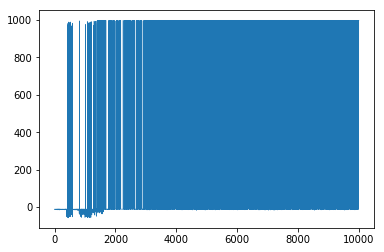

In [64]:
print("Win rate: {}".format(wins/float(num_episodes)))
plot(range(num_episodes),rList,lw=0.5)
show()

p = [1.0, 1.0]: Probs = [0.0, 0.0, 1.0, 0.0]
p = [1.0, 2.0]: Probs = [0.0, 1.0, 2.9910341e-30, 0.0]
p = [2.0, 2.0]: Probs = [0.0, 1.0, 0.0, 0.0]
p = [2.0, 3.0]: Probs = [0.0, 1.0, 0.0, 4.5910061e-34]
p = [3.0, 3.0]: Probs = [0.0, 1.0, 0.0, 0.0]
p = [4.0, 3.0]: Probs = [0.0, 1.0, 0.0, 0.0]
p = [5.0, 3.0]: Probs = [0.0, 0.0, 0.0, 1.0]
p = [5.0, 2.0]: Probs = [0.0, 0.0, 0.0, 1.0]


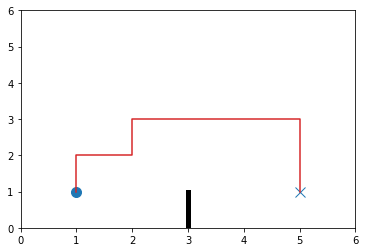

In [66]:
for i in range(len(xList[-1])-1):
    print("p = {}: Probs = {}".format([xList[-1][i],yList[-1][i]],list(probList[-1][i])))

plot(1,1,'C0o',ms=10)
plot(5,1,'C0x',ms=10)
plot(xList[-1],yList[-1],'C3-')
plot([3,3],[0,1],'k-',lw=5)
xlim([0,6])
ylim([0,6])
show()